In [18]:
from rai_toolbox.datasets import MNISTC
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from math import floor
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

Files already downloaded and verified
70000
2  4  7  7


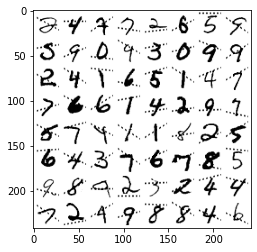

In [31]:

# Basic transform to convert from PIL format (default return type) to a
# tensor so PyTorch can train with it
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

mnistc = MNISTC("data", "dotted_line", "combined", transform, None, True)
print(mnistc.__len__())

# Custom split example
split_percent = 0.9
d1_size = floor(mnistc.__len__() * split_percent)
d2_size = mnistc.__len__() - d1_size
d1, d2 = random_split(mnistc, [d1_size, d2_size])
training_loader = DataLoader(d1, batch_size=64)
validation_loader = DataLoader(d2, batch_size=64)

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Class labels
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [26]:
# PyTorch models inherit from torch.nn.Module
class CharacterClassifier(nn.Module):
    def __init__(self):
        super(CharacterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CharacterClassifier()

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8111, 0.5864, 0.3284, 0.2776, 0.2370, 0.6758, 0.5193, 0.6275, 0.8249,
         0.8893],
        [0.9667, 0.9835, 0.1708, 0.9411, 0.0549, 0.3122, 0.3092, 0.6093, 0.9174,
         0.6061],
        [0.8528, 0.4907, 0.4708, 0.6545, 0.3356, 0.3554, 0.6830, 0.4558, 0.3342,
         0.2794],
        [0.0740, 0.7039, 0.1726, 0.2945, 0.9483, 0.1873, 0.3117, 0.2196, 0.1815,
         0.3154]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.391918659210205


In [28]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [29]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [30]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 0.7562166452407837
EPOCH 2:
LOSS train 0.0 valid 0.33792877197265625
EPOCH 3:
LOSS train 0.0 valid 0.22425229847431183
EPOCH 4:
LOSS train 0.0 valid 0.17319752275943756
EPOCH 5:
LOSS train 0.0 valid 0.1466604769229889
